# Report for the sleep data project

## Introduction


The purpose of this project is to use ensemble methods to discriminate between different sleep stages from EEG sleep data. We experiment with different ensemble methods and parameters in order to compare the results and find the most appropriate approach given our data.

We first prepare and filter the data for further use. Then perform Wavelet decomposition to identify and extract different frequencies from the data. Subsequently, we do feature extraction, where features correspond to the power of the frequency bands. Afterwards, we train and test two different ensemble methods; Random Forest and Adaboost. In order to optimize these results we then perform hyperparameter search and compare the results. To finish we propose and implement further methods to optimize classification.


## Sleep Data Description

Data was collected with the Traumschreiber, high-tech sleep mask developed for research purposes.

The data used to train and test the classifier consists of five data sets corresponding to different nights of sleep. Each data set containing information from seven Electroencephalogram (EEG) channels and one Electrocardiogram (ECG) channel, recorded for about seven hours of sleep.

Data is labeled by epochs of one second, where each second contains about 200 microvolt points. These labels correspond to the sleep stages introduced by the American Academy of Sleep Medicine (AASM) that differentiates between five main sleeping stages: 

(1) Wakefulness: Active wakefulness with beta waves (+13 Hz) and relaxed wakefulness with mostly alpha wave (8-13 Hz).
(2) Non-Rapid Eye Movement (NREM) 1: Dominated by Theta activity (4-7 Hz).
(3) NREM-2: Characterized by Theta waves, sleep spindles and K-complexes.
(4) NREM-3: Dominated by Delta wave (0.5-2 Hz) along with some sleep spindles.
(5) Rapid Eye Movement (REM): Characterized by low-amplitude mixed-frequency brain waves. Theta, alpha and even beta activity can be observed.


In [11]:
import pywt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage    
import scipy.signal    
import os
import pickle
from feature_extractor import *

In [14]:
# read the data for subject a
data = pd.read_csv('../data/by_subject/a_data.csv')
labels = pd.read_csv('../data/by_subject/a_labels.csv')

### Median filter justification

The data presented huge peaks that where probably product of interference in the Bluetooth signal. To eliminate peaks while altering the data as little as possible, we decided to implement a median filter by using the Scikit median filter function, with a Kernel size of three. This filter runs through the signal entry by entry, replacing each entry with the median of neighboring entries. The pattern of neighbors is referred as the Kernel size.

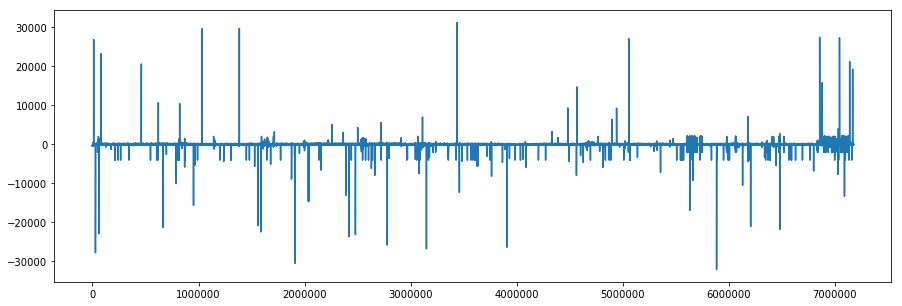

In [15]:
# Example Plot from data set 1, EEG channel 0
plt.figure(figsize = (15,5))
plt.plot(data['Ch0'])
plt.show()

In [16]:
# Median filter implemented to all channels

def median_filter(data):
    processed_data = data.copy()
    all_channels_data = data[['Ch0','Ch1','Ch2','Ch3','Ch4','Ch5','Ch6','Ch7']]
    for ch in all_channels_data:
        processed_data[ch] = scipy.signal.medfilt(data[ch], kernel_size=3)
      
    return processed_data

processed_data = median_filter(data)


In [25]:
import collections
#group datapoints into bins, corresponding to a second 
data['TimestampToSec'] = data['Timestamp'].astype(int)
grouped = data.groupby('TimestampToSec')
# group datapoints into bins, corresponding to 30 seconds of recording
print(grouped.head())
def epochs_30_seconds():
#print(labels.head())
    data_groups = collections.Counter(grouped)
    print(data_groups) #Counter({2: 4, 0: 3, 1: 3})
    #for name, group in grouped:
    #print(name)
    #print(group)
    return 0

epochs_30_seconds()

              Id     Timestamp  Ch0   Ch1  Ch2  Ch3   Ch4   Ch5  Ch6   Ch7  \
0              1  1.489016e+09 -321  -195  601  287   387   599  434    53   
1              2  1.489016e+09 -320  -197  591  287   395   596  418   276   
2              3  1.489016e+09 -345  -156  614  285   399   595  405   243   
3              4  1.489016e+09 -355  -181  628  304   389   581  396   244   
4              5  1.489016e+09 -362  -204  625  307   390   567  395   331   
82            83  1.489016e+09 -433  -343  689  349   449   624  447   -73   
83            84  1.489016e+09 -418  -333  687  337   441   595  406    46   
84            85  1.489016e+09 -437  -339  703  353   440   609  407    61   
85            86  1.489016e+09 -468  -355  709  363   441   617  411  -274   
86            87  1.489016e+09 -442  -364  701  358   441   628  433   223   
321          322  1.489016e+09 -356  -520  808  479   522   760  528   267   
322          323  1.489016e+09 -353  -517  811  483   535   761 

TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed

In [ ]:
# plot data before and after median filter for all channels
channels = ['Ch0','Ch1','Ch2','Ch3','Ch4','Ch5','Ch6','Ch7']
title = ['Channel 0','Channel 1','Channel 2','Channel 3','Channel 4','Channel 5','Channel 6','Channel 7']
color = ['red','blue','green','yellow','orange','black','purple', 'grey']

for i,channel in enumerate(channels):
    
    f, (ax1, ax2) = plt.subplots(2,figsize = (15,5), sharex=True, sharey=True)
    ax1.plot(data[channel], color = color[i])
    ax1.set_title(title[i]+' before median filter')
    ax2.plot(processed_data[channel], color = color[i])
    ax2.set_title(title[i]+' after median filter')
    plt.show()

## Discrete Wavelet Transform

### Discrete Wavelet Transform Overview
The wavelet are waves of irregular form in shape and compactly supported. These properties along with the main two operations of scaling and shifting, which produce a time-scale representation of the signal, make wavelets an ideal tool for analysing signals of non-stationary nature. Their irregular shape makes them suitable for analysing signals with discontinuities, and their compactly supported nature enables temporal localisation. Motivated by the adaptive time-frequency resolution properties of the Wavelet Transform and the corresponding fact that some stages in sleep recordings have a well defined time-frequency domain we opted to use Discrete Wavelet Decomposition to obtain five sub-bands of the original signal and consequently performed feature extraction on them for the classification.

The Discrete Wavelet Decomposition algorithm we implemented relays firstly on a dyadic scaling of the wavelength and secondly on a discrete shifting across the original signal. The first operation serves as half band filter which halves the highest frequency component of the original signal,providing  lower computational time and less memory usage. This in accordance to Nyquist’s sampling rate allowing the usage of half of the previous sample points at each level of the decomposition for a proper reconstruction of the original signal. 




<img src="wavelet transform EEG ERD ERS event-related potentials time frequencya.jpg">

### Feature Extraction for sleep classification 

In [ ]:
mode = pywt.Modes.smooth

def signal_decomp(data):
    """Decompose and plot a signal S.
    S = An + Dn + Dn-1 + ... + D1
    """
    w = pywt.Wavelet('db4')
    a = data
    ca = []
    cd = []
    for i in range(5):
        (a, d) = pywt.dwt(a, w, mode)
        ca.append(a)
        cd.append(d)  
    return ca, cd

In [ ]:
def Energy(coeffs, k):
    return np.sqrt(np.sum(np.array(coeffs[-k]) ** 2)) / len(coeffs[-k])

### Signal Decomposition
The algorithm adopted can be better visualized as a tree of low and high pass filter, which perform the decomposition of the signal into different frequency bands applying successive filtering of the time domain signal. 
The original signal is successively decomposed into components of lower resolution, while the high frequency components are not analysed any further.This decomposition halves the time resolution since only half the number of samples now characterizes the entire signal. 
However it doubles the frequency resolution, since the frequency band of the signal now spans only half the previous.The maximum depth of decomposition is dependent on the input size of the data to be analysed, with 2N data samples enabling the breakdown of the signal into N discrete levels using the discrete wavelet transform. This procedure thus offers a good time resolution at high frequencies, and good frequency resolution at low frequencies. 

This matches well the resolution of each sub-band with certain sleep stages patterns, for example capturing at an higher time resolution the signal of the beta stage, which shows abrupt discontinuities .
We discarded the first two levels of the decomposition simply because those frequency bands are completely absent it the original signal. In conclusion the frequencies that are most prominent in the original signal will appear as high amplitudes in the corresponding region of the Discrete Wavelet Transform signal that includes those particular frequencies.




<img src="Untitled Diagram (3).png">

In [ ]:
def plot_signal_decomp(data, w, title):
    ca, cd = signal_decomp(data)
        
    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(pywt.waverec(coeff_list, w))

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(pywt.waverec(coeff_list, w))

    fig = plt.figure(figsize=(12,10))
    ax_main = fig.add_subplot(len(rec_a) + 1, 1, 1)
    ax_main.set_title(title, fontsize=20)
    ax_main.plot(data)
    ax_main.set_xlim(data.index[0], data.index[len(data) - 1])

    for i, y in enumerate(rec_a):
        ax = fig.add_subplot(len(rec_a) + 1, 2, 3 + i * 2)
        ax.plot(y, 'r')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylabel("A%d" % (i + 1))

    for i, y in enumerate(rec_d):
        ax = fig.add_subplot(len(rec_d) + 1, 2, 4 + i * 2)
        ax.plot(y, 'g')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylabel("D%d" % (i + 1))


In [ ]:
plot_signal_decomp(single_sec_ch, 'db4', "Single Sec single Channel EEG data")
plt.show()

### ignore from here

In [ ]:
# CONSTRUCT FEATURES

# for every label, look up the corresponding data
features = []
for l in range(len(labels)):
    try:
        time = labels['Timestamp'][l]
        slice = grouped.get_group(time)
    except KeyError:
        print(time)
        pass
    # for every channel
    power_all_channels = []
    # 1-7 EEG, 8th channel is ECG data
    for ch in range(8):
        single_sec_ch = slice['Ch{}'.format(ch)]
        
        # median filter the data
        pre_processed = scipy.signal.medfilt(single_sec_ch, kernel_size=3)  
        
        _, cd = signal_decomp(pre_processed)
        # for every decomp. level
        power = []
        for l in range(5):
            power.append(Energy(cd, l))
            
        # collect power for all channels into one vector 
        power_all_channels.append(power) 
    # currently mean power of the frequency bands over all channels are the only features
    power_vec = np.asarray(power_all_channels).flatten()
    features.append(power_vec)
features =np.asarray(features)
 

In [ ]:
print(features.shape)

## Classification

### Load all the features
If no features are available run the feature_extractor.py to get the feature files

In [ ]:
from sklearn import ensemble
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import randint as sp_randint




In [ ]:
features = pd.read_csv("../data/precomputed_features/features.csv")
targets = pd.read_csv("../data/precomputed_features/targets.csv")
targets.columns = ['stages']

### Create a separate test set to test our classifiers on

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(
...     features, targets['stages'], test_size=0.33, random_state=0)


### General Set up
 10 fol crossvalidation, Random Search for hyperparamters

In [ ]:
# Utility function to report best scores for Random Search
def report(results, n_top=n_iter_search):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

### Random Forest

In [ ]:
# run randomized search
n_iter_search = 20


## Random Forst
clf = ensemble.RandomForestClassifier(n_estimators = 10, criterion='entropy', class_weight='balanced', n_jobs = -1)


# specify parameters and distributions to sample from
param_dist = {"n_estimators":sp_randint(1, 100),
              "max_depth": [3, None],
              "max_features": sp_randint(1, 40),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}


random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)


In [ ]:
#bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'n_estimators': 61

## Random Forst
rf_clf = ensemble.RandomForestClassifier(n_estimators = 73, criterion='entropy', class_weight='balanced', max_features=21, n_jobs = -1)


rf_predicted = cross_val_predict(rf_clf, X_train, y_train, cv=10)

rf_acc = metrics.accuracy_score(y_train, rf_predicted)
print("This is the Score: {}".format(rf_acc))


### AdaBoost

In [ ]:
# run randomized search
n_iter_search = 20

## AdaBoost
clf = ensemble.AdaBoostClassifier()


# specify parameters and distributions to sample from
param_dist = {"n_estimators":sp_randint(50, 250),
              "algorithm": ["SAMME", "SAMME.R"],
              "base_estimator": [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)]
             }


random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

In [ ]:
#bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'n_estimators': 61

## Random Forst
ada_clf = ensemble.AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth=3),n_estimators=188, algorithm ='SAMME.R')


ada_predicted = cross_val_predict(ada_clf, X_train, y_train, cv=10)

ada_acc = metrics.accuracy_score(y_train, ada_predicted)
print("This is the Score: {}".format(ada_acc))


### Smoothing Bayesian

## Results

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    if normalize:
        float_formatter = lambda x: "%.2f" % x
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, float_formatter(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=18)
        else:
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=18)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)

In [ ]:
# get class names for labels of plot
class_names, counts = np.unique(y_train, return_counts=True)
    
# Compute confusion matrix
np.set_printoptions(precision=2)

rf_cnf_matrix = confusion_matrix(y_train, rf_predicted)
ada_cnf_matrix = confusion_matrix(y_train, ada_predicted)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))

plt.subplot(121)
plot_confusion_matrix(rf_cnf_matrix, classes=class_names,
                      title='Confusion matrix for the Random Forest ')

# Plot normalized confusion matrix
plt.subplot(122)
plot_confusion_matrix(ada_cnf_matrix, classes=class_names,
                      title='Confusion matrix for the Ada Boost Classifiers')

plt.show()

### Test Set

In [ ]:
rf_clf.fit(X_train,y_train)
ada_clf.fit(X_train,y_train)


rf_pred_test = rf_clf.predict(X_test)
ada_pred_test = ada_clf.predict(X_test)


rf_acc_test = metrics.accuracy_score(y_test, rf_pred_test)
print("This is the Score for Random Forest on the test set: {}".format(rf_acc_test))

ada_acc_test = metrics.accuracy_score(y_test, ada_pred_test)
print("This is the Score for Ada-Boost on the test set: {} \n \n".format(ada_acc_test))

rf_cnf_matrix_test = confusion_matrix(y_test, rf_pred_test)
ada_cnf_matrix_test = confusion_matrix(y_test, ada_pred_test)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))
plt.subplot(121)
plot_confusion_matrix(rf_cnf_matrix_test, classes=class_names,
                      title='Confusion matrix for the Random Forest for the test set')

# Plot normalized confusion matrix
plt.subplot(122)
plot_confusion_matrix(ada_cnf_matrix_test, classes=class_names, normalize=False,
                      title='Confusion matrix for the Random Forest for test set')

plt.show()

## Conclusion